## Project Overview
This project applies deep learning to upscale low-resolution images into higher-resolution outputs.
We use the Oxford-IIIT Pet dataset and train a lightweight convolutional model to reconstruct HR images from bicubic-downsampled LR inputs.

Training combines pixel loss with VGG16-based perceptual loss, enabling the model to recover sharper edges and textures beyond standard interpolation.

Key components:
* Custom dataset for LR/HR pairs
* Bicubic downsampling and resizing
* Lightweight CNN for image-to-image regression
* Perceptual loss using VGG16 intermediate features
* Training loop with MSE + perceptual objective
* Visual comparison of LR / HR / Generated results

### Imports

In [1]:
# !pip install torch torchvision torchaudio --upgrade --quiet
# !pip install pillow --quiet
# !pip install matplotlib --quiet
# !pip install numpy --quiet
# !pip install requests --quiet


In [ ]:
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.models as models
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import lr_scheduler

import numpy as np
import time
import copy
import torch.nn.functional as F

import matplotlib.pyplot as plt
import torch
import torchvision.models as models


### Step 1: Create dataset

In [ ]:
class PetsSuperResDataset(Dataset):
    def __init__(self, split='train', hr_size=(256, 256)):
        # The dataset uses split='trainval' or 'test'
        self.dataset = torchvision.datasets.OxfordIIITPet(
            root='./data',
            split=split,
            download=True
        )

        self.hr_size = hr_size

        self.to_tensor = transforms.ToTensor()

        # Light augmentation (optional)
        self.augment = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(
                brightness=0.1,
                contrast=0.1,
                saturation=0.1
            )
        ])

        # Create HR and LR transforms
        self.hr_transform = transforms.Resize(
            hr_size,
            interpolation=transforms.InterpolationMode.BICUBIC
        )

        self.lr_transform = transforms.Compose([
            transforms.Resize(
                (hr_size[0] // 2, hr_size[1] // 2),
                interpolation=transforms.InterpolationMode.BICUBIC
            ),
            transforms.Resize(
                hr_size,
                interpolation=transforms.InterpolationMode.BICUBIC
            )
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]  # ignore target

        img = self.augment(img)

        hr_img = self.hr_transform(img)
        lr_img = self.lr_transform(hr_img)

        hr_tensor = self.to_tensor(hr_img)
        lr_tensor = self.to_tensor(lr_img)

        return lr_tensor, hr_tensor


In [4]:
batch_size = 16

image_train = PetsSuperResDataset(split='trainval', hr_size=(256, 256))
image_val   = PetsSuperResDataset(split='test', hr_size=(256, 256))

dataset_sizes = {
    'train': len(image_train),
    'val': len(image_val),
}

dataloaders = {
    'train': torch.utils.data.DataLoader(
        image_train, batch_size=batch_size, shuffle=True, num_workers=2
    ),
    'val': torch.utils.data.DataLoader(
        image_val, batch_size=batch_size, shuffle=False, num_workers=2
    ),
}


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

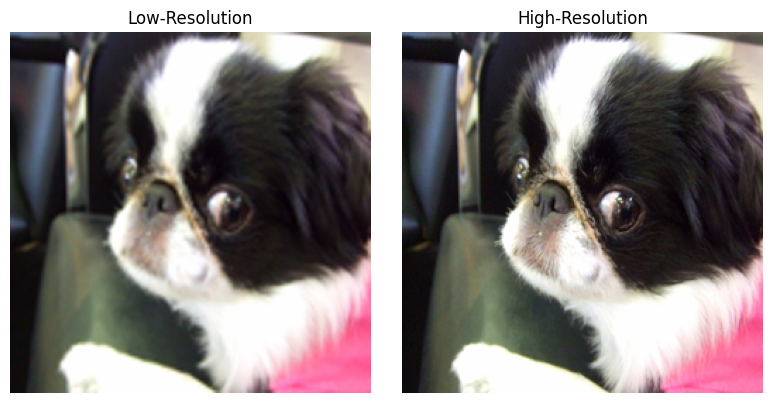

In [6]:
def show_high_low_res_pair(lr, hr, gen=None):
    lr_img = to_pil_image(lr)
    hr_img = to_pil_image(hr)

    images = [lr_img, hr_img]
    titles = ['Low-Resolution', 'High-Resolution']

    if gen is not None:
        gen_img = to_pil_image(gen)
        images.append(gen_img)
        titles.append('Generated Res')

    num_images = len(images)
    plt.figure(figsize=(4 * num_images, 4))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()


train_iter = iter(dataloaders['train'])
lr_batch, hr_batch = next(train_iter)

show_high_low_res_pair(lr_batch[0], hr_batch[0])

### Step 2: Simple CNN model

The model uses a simple 3-layer convolutional neural network for super-resolution. It takes a low-resolution RGB image and predicts a sharpened high-resolution version of the same size. The architecture expands the input into a richer feature space, refines it, and then projects it back to RGB.

This design is intentionally lightweight:
* It has a large receptive field (9×9) in the first layer to capture global context.
* It uses nonlinear feature transformation through ReLU activations.
* It outputs RGB with a final 5×5 convolution.

This model serves as a baseline for learning the core idea of super-resolution: predicting missing detail directly from the low-resolution input.


In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.convo = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=5, stride=1, padding=2)
        )

    def forward(self, x):
        x = self.convo(x)
        return x

### Step 3: Training the model

### Perceptual Loss: Why and How
If we only use pixel-wise MSE:
'''
L_MSE = mean( (y_hat - y_true)^2 )
'''
the model is penalized for every per-pixel deviation. In super-resolution this often leads to:
* Overly smooth and blurry images.
* Loss of fine textures and realistic details.
* “Averaging” of plausible solutions when multiple high-frequency patterns would all be valid.

Human perception, however, is much more sensitive to:
* Edges and contours
* Local structures and textures
* Object parts and semantic regions

### Idea of perceptual loss
Perceptual loss replaces (or complements) pixel loss by measuring similarity not in pixel space, but in the feature space of a fixed pretrained network (here, VGG16 trained on ImageNet).

Intuition:

* A pretrained network’s intermediate feature maps respond to edges, textures, and object-level patterns.
* If two images have similar activations in these layers, they are likely to look similar to humans.

=> we want the generated image and the target HR image to have similar VGG16 feature maps.

Let:

* G(x) be the super-resolution model output for a low-res image x.
* y be the ground-truth high-res image.
* phi_l(·) be the activation (feature map) of VGG16 at layer l.

Perceptual (content) loss is:
'''
L_perceptual = sum_over_layers_l  mean( (phi_l(G(x)) - phi_l(y))^2 )
'''

so we will have to combine pixel and perceptual terms:
'''
total_loss = mse_loss + perceptual_weight * perceptual_loss
'''
where perceptual_weight controls how strongly we enforce feature-space similarity compared to raw pixel similarity.

In [8]:
def perceptual_loss_fn(outputs, targets, pl_model):
    """
    Compute perceptual loss between outputs and targets using VGG16 features.
    """
    # Define normalization for VGG16
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    # Clone inputs
    x_output = outputs.clone()
    x_target = targets.clone()

    # Normalize for VGG16
    x_output = normalize(x_output)
    x_target = normalize(x_target)

    target_layers = {
        '3': 'relu1_2',
        '8': 'relu2_2',
        '15': 'relu3_3',
        '22': 'relu4_3'
    }

    output_features = {}
    target_features = {}
    x_output = x_output.clone()
    x_target = x_target.clone()

    for name, layer in pl_model._modules.items():
        x_output = layer(x_output)
        x_target = layer(x_target)
        if name in target_layers:
            layer_name = target_layers[name]
            output_features[layer_name] = x_output.clone()
            target_features[layer_name] = x_target.clone()

    perceptual_loss = 0.0
    for layer_name in target_layers.values():
        layer_loss = F.mse_loss(output_features[layer_name], target_features[layer_name])
        perceptual_loss += layer_loss

    return perceptual_loss

In [20]:
def psnr(gen, target, max_val=1.0):
    mse = F.mse_loss(gen, target, reduction='mean')
    return 10 * torch.log10(max_val**2 / mse)


In [21]:
def train_model(model, pl_model, dataloaders, criterion, optimizer, scheduler,
                dataset_sizes, num_epochs=25, perceptual_weight=0.01):

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    # Now store: row 0 = MSE, row 1 = perceptual, row 2 = PSNR
    train_res = np.zeros((3, num_epochs))
    val_res   = np.zeros((3, num_epochs))

    dict_res = {'train': train_res, 'val': val_res}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            pl_model.eval()

            running_mse = 0.0
            running_perc = 0.0
            running_total = 0.0
            running_psnr = 0.0

            total_batches = len(dataloaders[phase])

            for batch_idx, (lr_images, hr_images) in enumerate(dataloaders[phase]):
                if batch_idx % 50 == 0:
                    print(f"Processing batch {batch_idx}/{total_batches}")

                lr_images = lr_images.to(device)
                hr_images = hr_images.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    gen_images = model(lr_images)

                    mse_loss = criterion(gen_images, hr_images)
                    perc_loss = perceptual_loss_fn(gen_images, hr_images, pl_model)
                    total_loss = mse_loss + perceptual_weight * perc_loss

                    if phase == 'train':
                        total_loss.backward()
                        optimizer.step()

                batch_size = lr_images.size(0)
                running_mse += mse_loss.item() * batch_size
                running_perc += perc_loss.item() * batch_size
                running_total += total_loss.item() * batch_size

                # PSNR on this batch
                batch_psnr = psnr(gen_images.detach(), hr_images.detach())
                running_psnr += batch_psnr.item() * batch_size

            if phase == 'train':
                scheduler.step()
                torch.cuda.empty_cache()

            epoch_mse = running_mse / dataset_sizes[phase]
            epoch_perc = running_perc / dataset_sizes[phase]
            epoch_total = running_total / dataset_sizes[phase]
            epoch_psnr = running_psnr / dataset_sizes[phase]

            print(f"{phase} MSE: {epoch_mse:.4f}, "
                  f"Perc: {epoch_perc:.4f}, "
                  f"PSNR: {epoch_psnr:.2f} dB, "
                  f"Total: {epoch_total:.4f}")

            dict_res[phase][0, epoch] = epoch_mse
            dict_res[phase][1, epoch] = epoch_perc
            dict_res[phase][2, epoch] = epoch_psnr

            if phase == 'val' and epoch_total < best_loss:
                best_loss = epoch_total
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val loss: {best_loss:.4f}')

    model.load_state_dict(best_model_wts)
    return model, dict_res


In [22]:
model = CNN().to(device)
criterion = nn.MSELoss()
vgg16 = models.vgg16(pretrained=True).features.eval().to(device)
for param in vgg16.parameters():
    param.requires_grad = False
optimizer_ft = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [23]:
num_epochs = 15
model, dict_res = train_model(model=model,
                             pl_model = vgg16,
                             dataloaders=dataloaders,
                             criterion=criterion,
                             optimizer=optimizer_ft,
                             scheduler=exp_lr_scheduler,
                             dataset_sizes=dataset_sizes,
                             num_epochs=num_epochs,
                             perceptual_weight=0.1
)

Epoch 0/14
----------
Processing batch 0/230
Processing batch 50/230
Processing batch 100/230
Processing batch 150/230
Processing batch 200/230
train MSE: 0.0078, Perc: 7.3180, PSNR: 25.31 dB, Total: 0.7396
Processing batch 0/230
Processing batch 50/230
Processing batch 100/230
Processing batch 150/230
Processing batch 200/230
val MSE: 0.0014, Perc: 5.6818, PSNR: 28.84 dB, Total: 0.5696

Epoch 1/14
----------
Processing batch 0/230
Processing batch 50/230
Processing batch 100/230
Processing batch 150/230
Processing batch 200/230
train MSE: 0.0015, Perc: 5.2485, PSNR: 28.40 dB, Total: 0.5264
Processing batch 0/230
Processing batch 50/230
Processing batch 100/230
Processing batch 150/230
Processing batch 200/230
val MSE: 0.0013, Perc: 5.2875, PSNR: 29.25 dB, Total: 0.5300

Epoch 2/14
----------
Processing batch 0/230
Processing batch 50/230
Processing batch 100/230
Processing batch 150/230
Processing batch 200/230
train MSE: 0.0015, Perc: 5.0864, PSNR: 28.41 dB, Total: 0.5102
Processing 

### Step 4: Summary

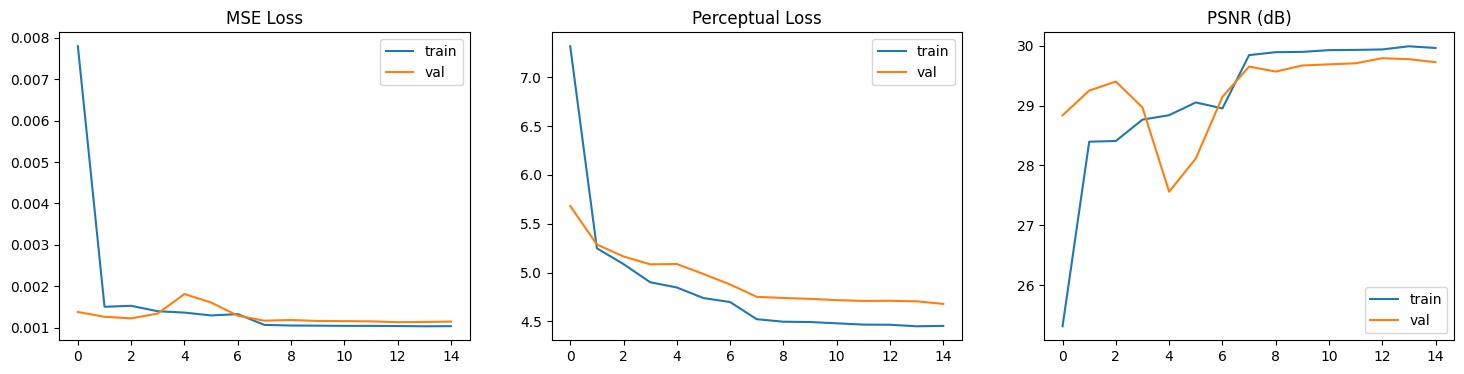

In [24]:
def plot_convergence(dict_res, num_epochs):
    plt.figure(figsize=(18,4))

    plt.subplot(1,3,1)
    plt.plot(dict_res['train'][0], label='train')
    plt.plot(dict_res['val'][0], label='val')
    plt.title("MSE Loss")
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(dict_res['train'][1], label='train')
    plt.plot(dict_res['val'][1], label='val')
    plt.title("Perceptual Loss")
    plt.legend()

    plt.subplot(1,3,3)
    plt.plot(dict_res['train'][2], label='train')
    plt.plot(dict_res['val'][2], label='val')
    plt.title("PSNR (dB)")
    plt.legend()

    plt.show()

plot_convergence(dict_res,num_epochs ); plt.show()

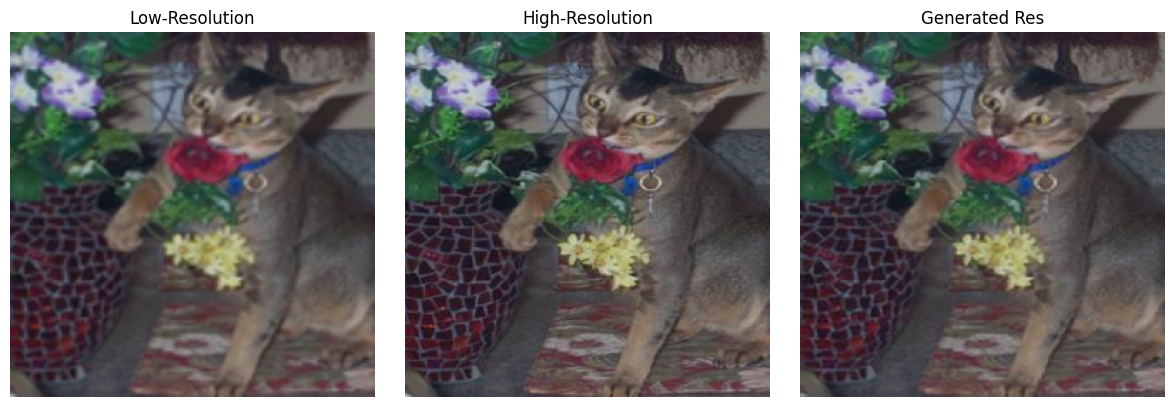

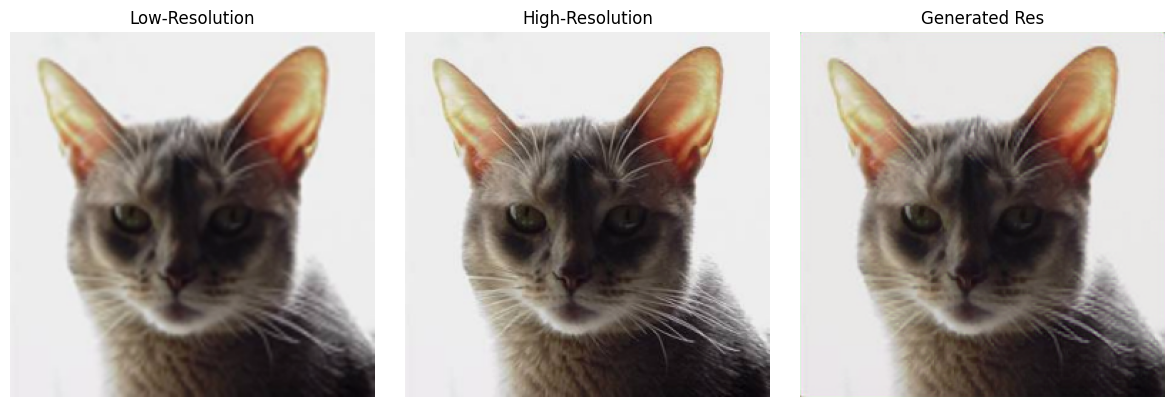

In [ ]:
for i in [3,4,5]:
    lr, hr = image_val[i]
    lr_in = lr.unsqueeze(0).to(device)
    gen = torch.clamp(model(lr_in), 0, 1)[0].cpu()
    show_high_low_res_pair(lr, hr, gen)


### Conclusion

The super-resolution model demonstrated stable and consistent learning across all 15 training epochs. Both the pixel-level MSE loss and the VGG-based perceptual loss steadily decreased on the training set, indicating that the network learned to reconstruct sharper and more detailed high-resolution outputs from blurred inputs. The validation curves closely followed the training curves, with minimal divergence, showing good generalization and no overfitting.

In addition to loss metrics, the PSNR (Peak Signal-to-Noise Ratio) improved throughout training for both train and validation sets, reaching stable values by the final epochs. This confirms that the model not only minimized reconstruction error but also produced perceptually cleaner, less noisy images.

This simple 3-layer CNN serves as a lightweight baseline and naturally has limitations: it lacks residual connections and deeper feature extraction capacity, so it cannot fully capture long-range dependencies or reproduce complex textures. More advanced super-resolution systems—such as SRCNN, FSRCNN, SRResNet, EDSR, and GAN-based ESRGAN—use deeper architectures, residual blocks, and adversarial training to generate significantly more realistic fine detail.

### Possible next steps to improve quality:

* Use a deeper architecture (SRCNN, FSRCNN, SRResNet, ESRGAN) for finer texture reconstruction.
* Add residual connections to stabilize training and reduce artifacts.
* Mix loss functions (e.g., L1 + perceptual + SSIM) for more natural outputs.
* Improve the LR–HR pipeline with more realistic downsampling and augmentation.
* Train on larger datasets (DIV2K, Flickr2K) for more generalizable detail recovery.